<img src="https://github.com/DSIMB/PoincareMSA/blob/master/.github/PoincareMSA_small_logo.png?raw=true" height="100" style="height:100px;margin-left: 0px;">

# Poincaré maps for visualization of large protein famillies

**Authors**: Anna Klimovskaia Susmelj <a href="https://orcid.org/0000-0002-1057-6690" target="_blank"><img alt="ORCID logo" src="https://info.orcid.org/wp-content/uploads/2019/11/orcid_16x16.png"></a>, Yani Ren, Yann Vander Meersche <a href="https://orcid.org/0000-0002-6680-8104" target="_blank"><img alt="ORCID logo" src="https://info.orcid.org/wp-content/uploads/2019/11/orcid_16x16.png"></a>, Jean-Christophe Gelly <a href="https://orcid.org/0000-0001-5138-361X" target="_blank"><img alt="ORCID logo" src="https://info.orcid.org/wp-content/uploads/2019/11/orcid_16x16.png"></a> and Tatiana Galochkina <a href="https://orcid.org/0000-0002-3608-5208" target="_blank"><img alt="ORCID logo" src="https://info.orcid.org/wp-content/uploads/2019/11/orcid_16x16.png"></a>

<p>
	PoincaréMSA is a computational tool for visualization of large protein families developed by <a href="https://doi.org/10.1093/bib/bbad103" target="_blank" data-bs-toggle="tooltip" style="text-decoration:none;" data-bs-placement="top" title="Susmelj A.K., Ren Y., Vander Meersche Y., Gelly J.C, Galochkina T. (2023). Poincaré maps for visualization of large protein families. Briefings in bioinformatics, -. https://doi.org/10.1093/bib/bbad103">Susmelj et al.</a> PoincaréMSA builds an interactive projection of an input protein multiple sequence alignment provided by the user or built on-the-flow from the target sequence. The underlying algorithm is based on Poincaré maps introduced by <a href="https://doi.org/10.1038/s41467-020-16822-4" target="_blank" data-bs-toggle="tooltip" style="text-decoration:none;" data-bs-placement="top" title="Klimovskaia, A., Lopez-Paz, D., Bottou, L. et al. Poincaré maps for analyzing complex hierarchies in single-cell data. Nat Commun 11, 2966 (2020).">Klimovskaia et al.</a>. It successfully reproduces both local proximities between protein sequences as well as global hierarchical structure of the data.
</p>
<p>
	You can find a step-by-step explication of PoincaréMSA construction on the <a href="https://www.dsimb.inserm.fr/POINCARE_MSA/tutorial.html" target="_blank">Tutorial</a> page and several examples of PoincaréMSA projection for protein families on the <a href="https://www.dsimb.inserm.fr/POINCARE_MSA/examples.html" target="_blank">Examples</a> page. The source code is available at <a href="https://github.com/DSIMB/PoincareMSA" target="_blank">https://github.com/DSIMB/PoincareMSA</a>.<br>
</p>
<p class="mb-1"><strong>Please use the following reference when citing the PoincaréMSA:</strong></p>
<p>Susmelj A.K., Ren Y., Vander Meersche Y., Gelly J.C., &amp; Galochkina T. (2023). Poincaré maps for visualization of large protein families. <i>Briefings in bioinformatics</i>, bbad103, <a href="https://doi.org/10.1093/bib/bbad103" target="_blank">https://doi.org/10.1093/bib/bbad103</a></p>

In [1]:
#Load dependencies
import os
import numpy as np
import pandas as pd
import subprocess
import json
import warnings
warnings.filterwarnings('ignore')

#Import visualization functions
from scripts.visualize_projection.pplots_new import read_embeddings, plot_embedding, plot_embedding_interactive, rotate, get_colors 
from scripts.prepare_data.mmseqs2_api import run_mmseqs2
from scripts.prepare_data.uniprot_idmapping_api import submit_id_mapping, check_id_mapping_results_ready, get_id_mapping_results_link, get_id_mapping_results_search
from scripts.build_poincare_map.poincare_maps_rotation import *
%matplotlib inline

#Create optional variables
path_annotation = ""

# Data import

In [2]:
# OPTIONS =================================================
#MSA in mfasta format
mfasta = "examples/globins/glob.mfasta"

#Annotation file (.csv) or UniProt ID list. (Emtpy strings for no annotations)
path_annotation_csv = "examples/globins/globin_colors_new.csv" #Optional (Default: "")
# OR
path_uniprot_list = ""   # Path or ""
#==========================================================


#Check files
#mfasta
nb_seq = 0
if os.path.isfile(mfasta):
    with open(mfasta, "r") as f_in:
        for line in f_in:
            if line[0] == ">":
                nb_seq += 1
    print(f"\nNumber of sequences found: {nb_seq}.")
else:
    print(f"File {mfasta} not found.")


#Check that only one path is selected
if path_annotation_csv and path_uniprot_list:
    raise ValueError("Use only one file path (path_annotation_csv OR path_uniprot_list).")

if path_annotation_csv:
    if os.path.isfile(path_annotation_csv):
        try:
            df_annotation = pd.read_csv(path_annotation_csv)
        except:
            raise ValueError("Annotation file is not in .csv format.")
        else:
            if len(df_annotation) != nb_seq:
                raise ValueError("Annotation file doesn't match the .mfasta file length.")

        print("\nAnnotation file correctly loaded.")
        annotation_names = ["proteins_id"] + list(df_annotation.loc[:, df_annotation.columns != 'proteins_id'].columns)
        print(f"{len(annotation_names)} annotations found: {annotation_names}.")
    else:
        print(f"File {path_annotation_csv} not found.")

elif path_uniprot_list:
    if os.path.isfile(path_uniprot_list):
        try:
            UnP_ids = np.genfromtxt(path_uniprot_list, dtype="str")
        except:
            raise ValueError("UniProt IDs file is not in a valid format.")
        else:
            if len(UnP_ids) != nb_seq:
                raise ValueError("UniProt IDs file doesn't match the .mfasta file length.")     

            #Split UniProtKB and UniParc IDs
            uniparc_ids = []
            uniprot_ids = []
            for unp in UnP_ids:
                if len(unp) == 13 and unp[:2] == "UP":
                    uniparc_ids.append(unp)
                else:
                    uniprot_ids.append(unp)

            #Fetch UniProtKB annotations
            job_id = submit_id_mapping(
                from_db="UniProtKB_AC-ID", to_db="UniParc", ids=uniprot_ids
            )

            if check_id_mapping_results_ready(job_id):
                link = get_id_mapping_results_link(job_id)
                results = get_id_mapping_results_search(link)

            #Fetch UniParc annotations
            job_id = submit_id_mapping(
                from_db="UniParc", to_db="UniParc", ids=uniparc_ids
            )

            if check_id_mapping_results_ready(job_id):
                link = get_id_mapping_results_link(job_id)
                results2 = get_id_mapping_results_search(link)

            #Create annotation dataframe
            df_annotation = pd.DataFrame(UnP_ids, columns=["UnP_ID"])
            df_annotation[["organism", "proteinName", "taxonId", "species", "genus", \
                           "family", "order", "class", "phylum", "clade", "superkingdom"]] = ""

            #Fill the annotation DataFrame
            for dict_res in results["results"] + results2["results"]:
                try:
                    unp = dict_res["from"]
                    prot_name = dict_res["to"]["uniParcCrossReferences"][0]["proteinName"]
                    df_annotation.loc[df_annotation["UnP_ID"] == unp, "proteinName"] = prot_name
                    scientific_name = dict_res["to"]["uniParcCrossReferences"][0]["organism"]["scientificName"]
                    taxid = dict_res["to"]["uniParcCrossReferences"][0]["organism"]["taxonId"]
                    df_annotation.loc[df_annotation["UnP_ID"] == unp, "organism"] = scientific_name
                    df_annotation.loc[df_annotation["UnP_ID"] == unp, "taxonId"] = taxid
                except KeyError:
                    continue

            #Add lineage from NCBI Taxonomist
            taxon_ids = df_annotation.loc[df_annotation["taxonId"].notnull(), 'taxonId'].to_numpy()
            taxon_ids = list(set(taxon_ids))
            taxon_ids = list(map(str, taxon_ids))
            bash_command = f"ncbi-taxonomist resolve -t {','.join(taxon_ids)}"
            list_taxon = subprocess.run(bash_command, shell=True, capture_output=True, text=True).stdout.strip().split("\n")

            if list_taxon != [""]:
                for taxon in list_taxon:
                    jsonString = taxon
                    taxon_dict = json.loads(jsonString)
                    query = taxon_dict["query"]
                    for lineage in taxon_dict["lineage"]:
                        rank = lineage["rank"]
                        if rank in ["species", "genus", "family", "order", "class", "phylum", "clade", "superkingdom"]:
                            name = lineage["name"]
                            df_annotation.loc[df_annotation["taxonId"] == int(query), rank] = name

            #Save annotation to csv
            path_annotation = "auto_annot.csv"
            df_annotation.to_csv(path_annotation, index=False)

            print("\nAnnotation correctly fetched.")
            annotation_names = ["proteins_id"] + list(df_annotation.loc[:, df_annotation.columns != 'proteins_id'].columns)
            print(f"{len(annotation_names)} annotations found: {annotation_names}.")
    else:
        print(f"File {path_uniprot_list} not found.")
else:
    print("No annotation file selected.")
    path_annotation = ""


Number of sequences found: 252.

Annotation file correctly loaded.
17 annotations found: ['proteins_id', 'tree1', 'tree2', 'tree3', 'tree4', 'full_name', 'short_name', 'full_species', 'short_species', 'evo_distance', 'Color_species', 'Domain', 'Kingdom', 'Phylum', 'Subphylum', 'Class', 'Genus'].


# Data preparation
Here we clean the input .mfasta alignment and translate each sequence to a vector ready for projection.

### Parameters for data preparation

In [3]:
# OPTIONS =================================================
# Job name
#Name for the output folder
out_name = "poincareMSA"
#----------------------------------------------------------
# Threshold for filtering gapped positions
#Positions with proportion of gaps above the given threshold are removed from the alignment.
#If your alignment is very gapped, you may want to increase this value.
gapth = 0.9 
#==========================================================


# Run data preparation
#Data preparation consists in `.mfasta` cleaning according to a gap threshold and
#translation of each sequence to the PSSM profile.
prep_parameters = "scripts/prepare_data" + " " + mfasta + " " + out_name + " " + out_name + " " + str(gapth)
bash_projection = "bash scripts/prepare_data/create_projection.sh " + prep_parameters
!{bash_projection}

Input file: examples/globins/glob.mfasta
Name of the protein family: glob
80 X aa replaced by gaps in 252 sequences
filter_gaps finished for examples/globins/glob.mfasta
mfasta2fasta finished for poincareMSA/poincareMSA.clean0.9.mfasta
80 X aa replaced by gaps in 252 sequences


# Projection

### Projection parameters

In [8]:
# OPTIONS =================================================
#Here you control different parameters of Poincaré maps.
#In our computational experiments the best results were achieved for the following values provided by default.
#The impact of different parameters is analyzed in the original paper [1].
knn = 5 #5
gamma = 2 #2
sigma = 1 #1
cospca = 0 #0
batchs = 4 #4
epochs = 1000 #1000
seed = 0
mode = 'precomputed'  # 'features' or 'precomputed'
distfile = 'out_cosine.csv'  # name of the distance file
#==========================================================


# Building projection and preparing data for visualization
#This step creates a projection of encoded sequences to a Poincaré disk.
#bash_pm = "python3 "+ "scripts/build_poincare_map/main.py --input_path " + out_name + "/fasta" + str(gapth) + " --output_path " + out_name + "/projections/ --gamma "+ str(gamma) +" --pca "+ str(cospca) + " --epochs "+ str(epochs) +" --seed "+ str(seed) + " --knn " + str(knn)
#bash_pm = "python3 "+ "scripts/build_poincare_map/main.py --input_path " + out_name + "/fasta" + str(gapth) + " --output_path " + out_name + "/projections/ --gamma "+ str(gamma) +" --pca "+ str(cospca) + " --epochs "+ str(epochs) +" --seed "+ str(seed) + " --knn " + str(knn) + " --mode " + mode
bash_pm = "python3 "+ "scripts/build_poincare_map/main.py --input_path " + out_name + "/fasta" + str(gapth) + " --output_path " + out_name + "/projections/ --gamma "+ str(gamma) +" --sigma " + str(sigma) +" --pca "+ str(cospca) + " --epochs "+ str(epochs) +" --seed "+ str(seed) + " --knn " + str(knn) + " --mode " + mode + " --distfile " + distfile

!{bash_pm}

CUDA: False
Random seed set as 0
252 proteins found in folder poincareMSA/fasta0.9.
No root detected
Prepare data: tensor construction
Prepare data: successfully terminated
252
Computing laplacian...
Laplacian computed in 0.04 sec
Computing RFA...
RFA computed in 0.00 sec
Starting training...
loss: 0.35713:  55%|█████████████▊           | 551/1000 [00:30<00:23, 18.74it/s]
Stopped at epoch 552
loss: 0.35713:  55%|█████████████▊           | 552/1000 [00:30<00:24, 18.26it/s]
PM computed in 30.23 sec

loss = 3.571e-01
time = 0.505 min


# Projection visualization

### Prepare data for visualization

In [9]:
# Prepare data for visualization
#Check that an annotation file was provided. Create a dummy one instead
if not path_annotation_csv:
    df_annotation = pd.DataFrame(list(zip(list(range(1,nb_seq+1)), np.full(nb_seq, "-", dtype=object))), columns=["id", "default"])
    df_annotation.to_csv("dummy_annotation.csv", index=False)
    path_annotation_csv = "dummy_annotation.csv"
    annotation_names = ["proteins_id"]

path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
df_embedding = read_embeddings(path_embedding, path_annotation_csv, withroot=False)

# save original coordinate before any rotation
df_embedding["pm1_com"] = df_embedding["pm1"]
df_embedding["pm2_com"] = df_embedding["pm2"]

#Here are different labels found in your annotation file (if one uploaded):
print(f"{len(annotation_names)} annotations found: {annotation_names}.")

17 annotations found: ['proteins_id', 'tree1', 'tree2', 'tree3', 'tree4', 'full_name', 'short_name', 'full_species', 'short_species', 'evo_distance', 'Color_species', 'Domain', 'Kingdom', 'Phylum', 'Subphylum', 'Class', 'Genus'].


### Create interactive plot

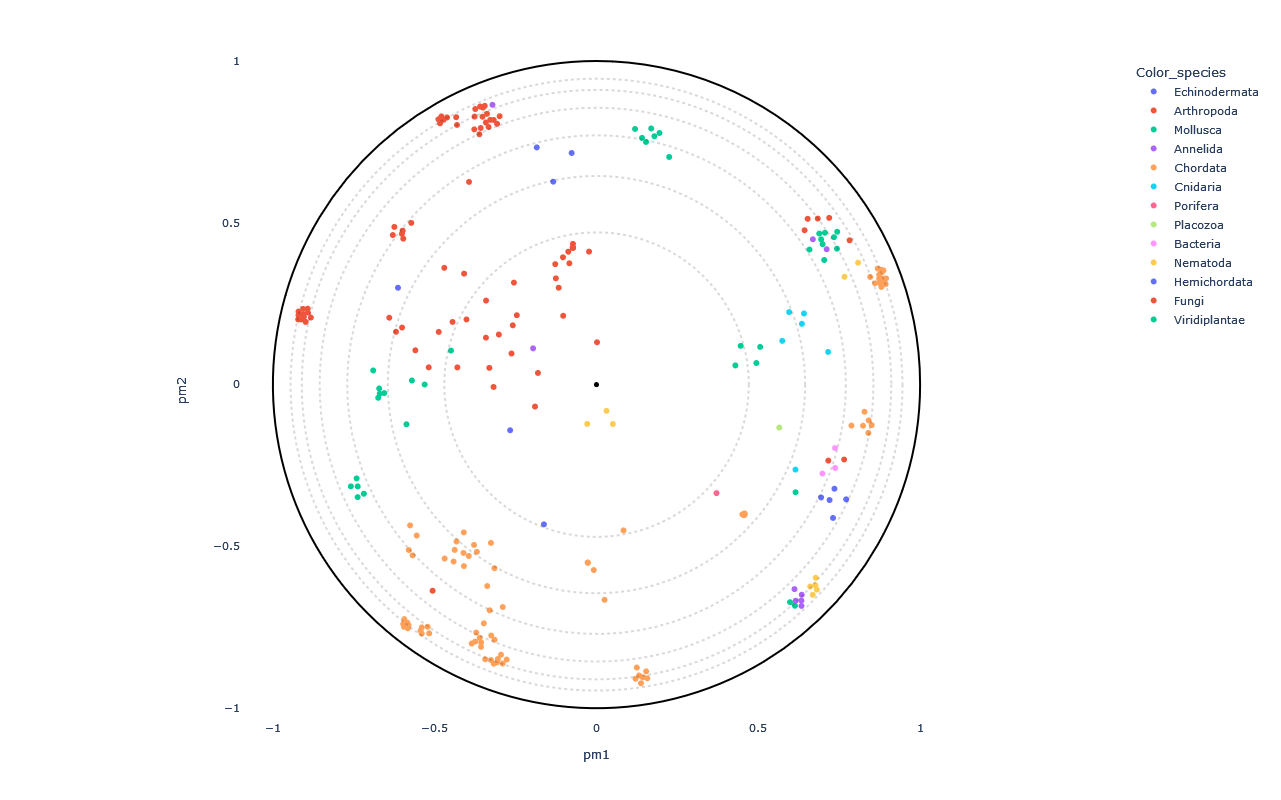

In [10]:
# OPTIONS =================================================
#Here you can set different parameters to color & annotate the resulting projection:
title = ""
#----------------------------------------------------------
# Select the coloring from annotation .csv file:
labels_name = "Color_species"
# Select classes to label among the "labels_name" or "second_labels_name" column (comma separated list):
second_labels_name = ""
labels_text = []
show_text = True
#----------------------------------------------------------
# Use a custom color palette:
color_palette = None #Default: None
use_custom_palette = False
# Select projection center:
id_for_rotation = None #Default: None
use_selected_center = False
#==========================================================


#Check projection visualization parameters
#Labels name
if labels_name == "":
    labels_name = None
elif labels_name not in annotation_names:
    raise NameError(f"labels_name {labels_name} is not in the availables annotations.\nAvailables annotations: {annotation_names}")
#Second labels name
if second_labels_name == "":
    second_labels_name = None
elif second_labels_name not in annotation_names:
    raise NameError(f'"second_labels_name" {second_labels_name} is not in the availables annotations.\nAvailables annotations: {annotation_names}')
#Color palet selection
if not use_custom_palette:
    color_palette = None
#Center of projection selection

tmp_id_for_rotation = -1
if use_selected_center and id_for_rotation is not None:
    if id_for_rotation != tmp_id_for_rotation:
        tmp_id_for_rotation = id_for_rotation

        poincare_coord = df_embedding[["pm1","pm2"]].sort_values(by=["proteins_id"])
        poincare_coord = poincare_coord.values[:,:2]
        model = PoincareMaps(poincare_coord)
        model.get_distances()

        model.iroot = id_for_rotation - 1  #Zero indexing
        model.rotate()

        df_embedding["pm1"] = model.coordinates_rotated[:,0]
        df_embedding["pm2"] = model.coordinates_rotated[:,1]
else:
    df_embedding["pm1"] = df_embedding["pm1_com"]
    df_embedding["pm2"] = df_embedding["pm2_com"]

#Plot graph
fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = labels_name,
                                 second_labels_name = second_labels_name, 
                                 show_text = show_text,
                                 labels_text = labels_text,
                                 color_palette = color_palette, 
                                 title = title, 
                                 fontsize = 11)
fig.show()

### Save plot to file

In [ ]:
# OPTIONS =================================================
output_name = "fig1"
output_format = "png" #Format availables: ["png", "html", "pdf", "svg"]
#==========================================================


if output_format != "html":
    fig.write_image(f"{output_name}.{output_format}", engine="kaleido")
else:
    fig.write_html(f"{output_name}.{output_format}")

In [13]:
# Added lines to saves the coordinates
concatenated_df = pd.concat([df_embedding["pm1"], df_embedding["pm2"]], axis=1)
print(concatenated_df)
concatenated_df.to_csv('euclidian_poincare.csv', index=False)

                  pm1       pm2
proteins_id                    
1           -0.160709  0.933369
2           -0.269561  0.311705
3           -0.459980  0.693353
4           -0.590908  0.641643
5           -0.596019  0.589880
...               ...       ...
248          0.714060  0.550677
249          0.716914  0.468325
250          0.651654  0.522008
251          0.647682  0.604669
252          0.748813  0.602164

[252 rows x 2 columns]
